In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,average_precision_score,roc_curve
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from data_treat.get_ready_data import get_data
from data_treat.data_normalizer import CustomNormalizer
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import roc_auc_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
COLUMNS = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price",
           "repeat_retailer","used_chip","used_pin_number","online_order","fraud"]

In [3]:
def feture_importants(importantance):
    res = ''
    for ind, imp in enumerate(importantance):
        res += f"{COLUMNS[ind]} :  {imp}\n"

    return res

In [4]:
data = get_data()

In [5]:
target_variable_name = 'fraud'
labels = data[target_variable_name]
data = data.drop(target_variable_name, axis=1)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.20,random_state=42)

In [7]:
#Создаём функцию для подбора лучших параметров модели
def model_func(x_train, x_test):
    def gridSearch(X,y):

        param_dict = {
        "criterion": ['gini', 'entropy'],
        "max_depth" : np.arange(1,10,2),
        "splitter": ['best', 'random'],
        }
        model = DecisionTreeClassifier(random_state=42)
        gv = GridSearchCV(model,param_grid=param_dict,cv=10)
        gv.fit(X,y)
        return gv.best_score_,gv.best_params_


    #Ищем лучшие параметры
    params = gridSearch(x_train,y_train)
    print(params)

    #Строим саму модель
    model = DecisionTreeClassifier(random_state=42,
                                criterion = params[1]["criterion"],
                                max_depth =  params[1]["max_depth"],
                                splitter =  params[1]["splitter"])

    #Обучаем
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)

    #Выводим оценку точности
    print ("Accuracy : ",accuracy_score(y_test,prediction)*100)
    print(classification_report(y_test, prediction))

    #Выводим матрицу ошибок
    print(confusion_matrix(y_test, prediction))

    #Получаем уверенность модели для всех предсказаний    
    test_probabilities = model.predict_proba(x_test)
    test_probabilities = test_probabilities[:, 1]
    false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

    #строим ROC-AUC кривую
    plt.figure(figsize=(7, 7))

    # рисуем кривую
    plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

    # кривая, соответствующая случайному угадыванию
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
    plt.legend()
    plt.show()

    #Получаем значениие площади под кривой для тестовой выборки
    roc_auc_value = roc_auc_score(y_test, test_probabilities)

    print("ROC-AUC на тестовой выборке:", roc_auc_value)


    print(feture_importants(model.feature_importances_))

    tree.plot_tree(model,feature_names=COLUMNS,class_names=True)

Для сырых данных

(0.9999284917478601, {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'})
Accuracy :  99.98283851038269
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17511
         1.0       1.00      1.00      1.00     17451

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962

[[17506     5]
 [    1 17450]]


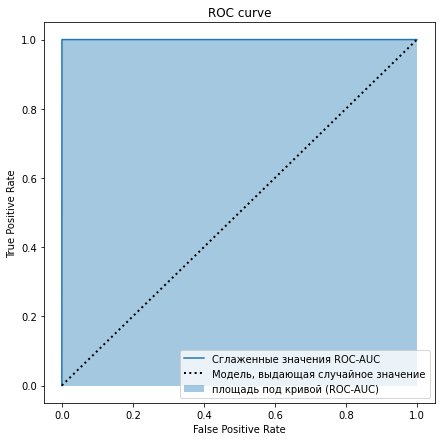

ROC-AUC на тестовой выборке: 0.9998285809434532
distance_from_home :  0.2646008792649549
distance_from_last_transaction :  0.11192953630783771
ratio_to_median_purchase_price :  0.5151561275334272
repeat_retailer :  0.013557659713871505
used_chip :  0.027886536526309298
used_pin_number :  0.01803634725150554
online_order :  0.04883291340209378



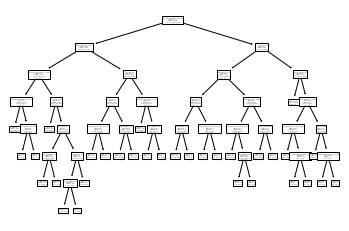

In [8]:
model_func(x_train, x_test)

Для нормализированных данных

(0.9999284927705314, {'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'})
Accuracy :  92.45466506492764
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     17404
         1.0       0.88      0.98      0.93     17558

    accuracy                           0.92     34962
   macro avg       0.93      0.92      0.92     34962
weighted avg       0.93      0.92      0.92     34962

[[15109  2295]
 [  343 17215]]


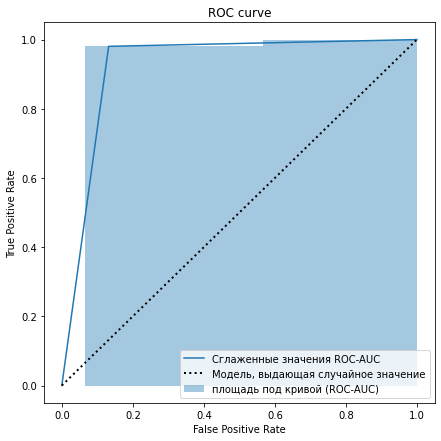

ROC-AUC на тестовой выборке: 0.9242992538843386
distance_from_home :  0.2556736346227201
distance_from_last_transaction :  0.16374668528258154
ratio_to_median_purchase_price :  0.4289958373416976
repeat_retailer :  0.0029934697631149045
used_chip :  0.03047251715157873
used_pin_number :  0.039057094003859816
online_order :  0.07906076183444742



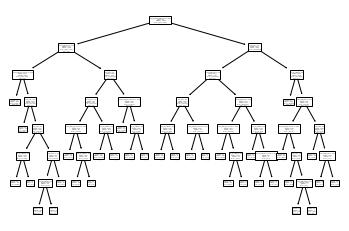

In [159]:
model_func(CustomNormalizer.normalize(x_train), CustomNormalizer.normalize(x_test))

Для Стандартизированных данных

(0.9999213417407832, {'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'})
Accuracy :  99.52519878725474
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     17404
         1.0       1.00      0.99      1.00     17558

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962

[[17367    37]
 [  129 17429]]


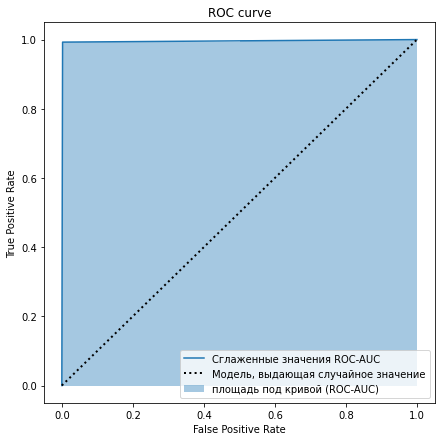

ROC-AUC на тестовой выборке: 0.9952634868435778
distance_from_home :  0.2556736346227201
distance_from_last_transaction :  0.16374668528258154
ratio_to_median_purchase_price :  0.4289958373416976
repeat_retailer :  0.0029934697631149045
used_chip :  0.03047251715157873
used_pin_number :  0.039057094003859816
online_order :  0.07906076183444742



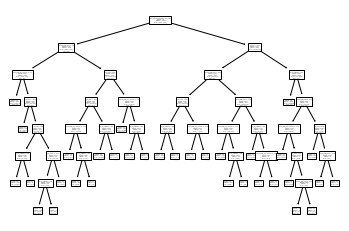

In [160]:
model_func(CustomNormalizer.standardize(x_train), CustomNormalizer.standardize(x_test))